# Liesel-GAM Demo Notebook

## Setup and Imports

In [7]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [8]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

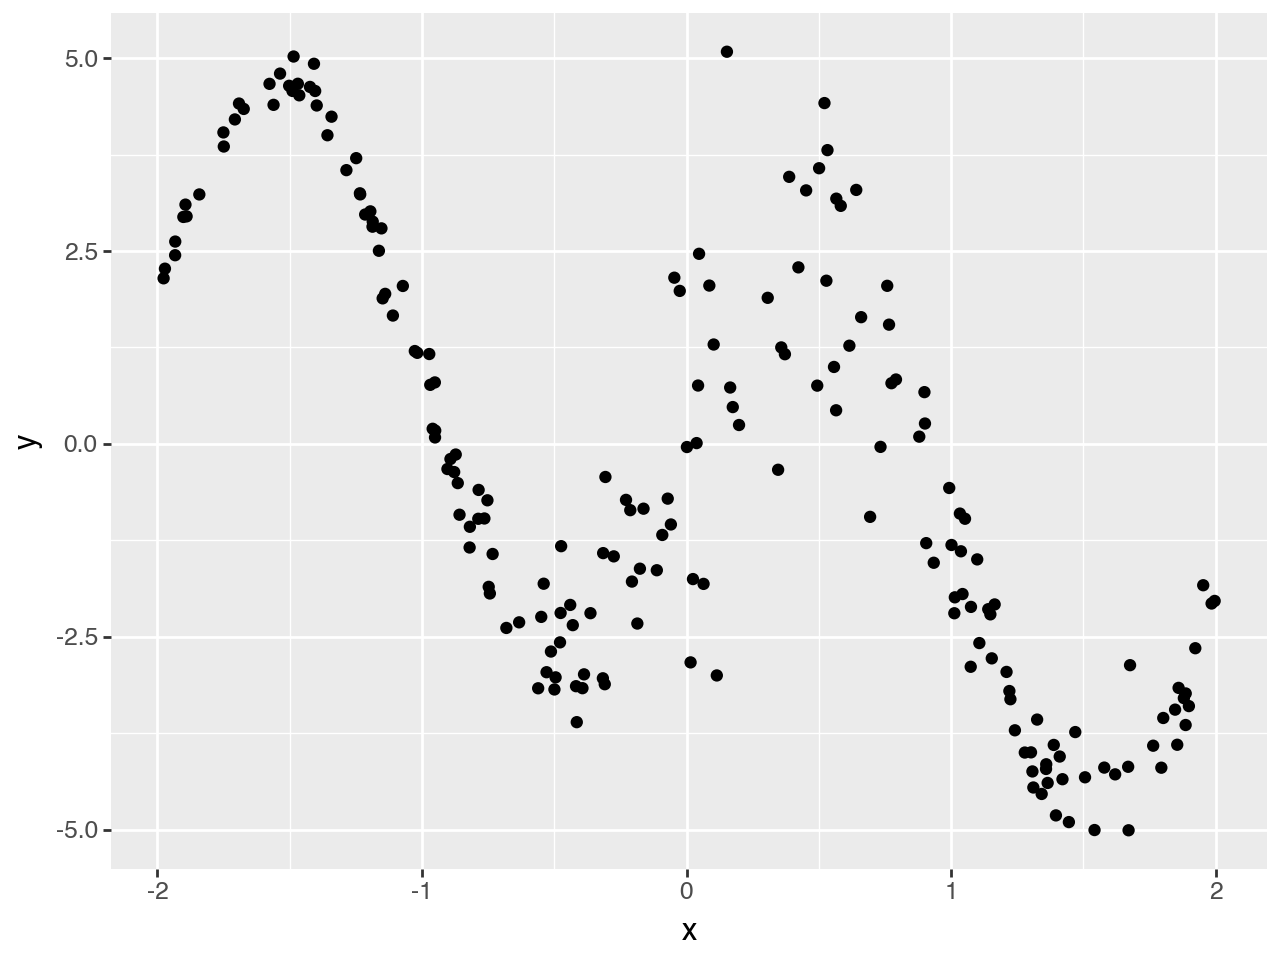

In [9]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

### Setup response model

In [10]:
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [11]:
loc += tb.s("x", k=20, bs="tp")
scale += tb.s("x", k=20, bs="tp")

### Build and plot model

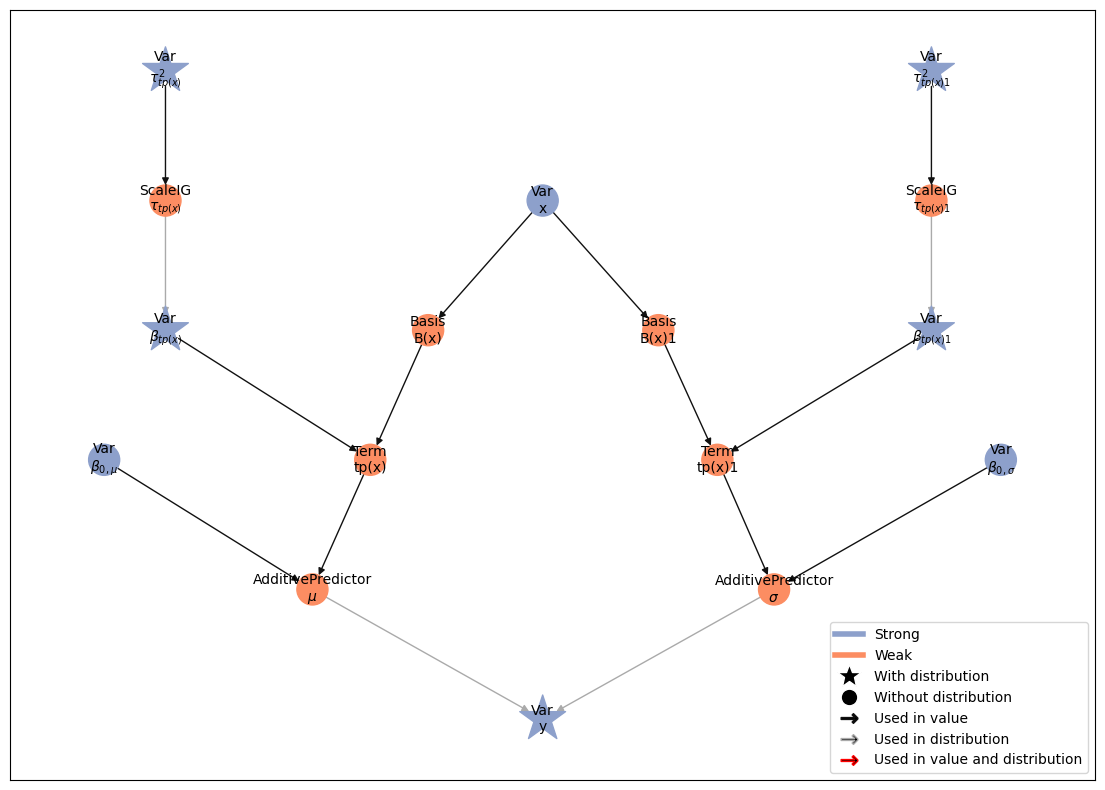

In [12]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [13]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{tp(x)1}$', '$\\tau^2_{tp(x)1}$', '$\\beta_{0,\\mu}$', '$\\beta_{tp(x)}$', '$\\tau^2_{tp(x)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:04<00:00,  3.44chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1156.09chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1672.37chunk/s]
liesel.goose.engine - INFO - 

### MCMC summary

In [14]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel        mean          sd      q_0.05  \
parameter          index                                                  
$\beta_{0,\mu}$    ()     kernel_03   -0.329988    0.097474   -0.425640   
$\beta_{0,\sigma}$ ()     kernel_00   -0.622709    0.115711   -0.719900   
$\beta_{tp(x)1}$   (0,)   kernel_01   -0.152050    3.639337   -5.833217   
                   (1,)   kernel_01   -0.723408    3.648177   -6.732102   
                   (2,)   kernel_01   -0.499165    3.594880   -6.222079   
                   (3,)   kernel_01   -0.154466    3.547714   -5.815194   
                   (4,)   kernel_01    0.162995    3.539158   -5.242839   
                   (5,)   kernel_01   -0.411017    3.495678   -6.148146   
                   (6,)   kernel_01    0.593999    3.578279   -4.729405   
                   (7,)   kernel_01    1.495598    3.881372   -3.719279   
                   (8,)   kernel_01   -0.105753    3.499707   -5.522169   
                   (9,)   kernel_01    0.611037    3.470758   -4.744813   
                   (10,)  kernel_01   -0.820282    3.464022   -6.259132   
                   (11,)  kernel_01    1.290408    3.822336   -3.013218   
                   (12,)  kernel_01    1.822515    3.052215   -2.664094   
                   (13,)  kernel_01   -5.014546    2.361061   -9.068956   
                   (14,)  kernel_01   -0.549655    2.332769   -4.072918   
                   (15,)  kernel_01    5.080740    0.995648    3.513142   
                   (16,)  kernel_01    0.088840    1.267097   -1.790199   
                   (17,)  kernel_01   -0.177525    2.067269   -3.566569   
                   (18,)  kernel_01    4.384855    8.306130   -7.598031   
$\beta_{tp(x)}$    (0,)   kernel_04   17.257549   12.259464   -2.190692   
                   (1,)   kernel_04   -8.610895   17.640898  -37.899508   
                   (2,)   kernel_04   -6.511938   15.896631  -33.374449   
                   (3,)   kernel_04    5.804492   12.697998  -14.912437   
                   (4,)   kernel_04    4.860954   17.552769  -22.660804   
                   (5,)   kernel_04    7.382656   10.677900   -9.727472   
                   (6,)   kernel_04   15.440059   13.628917   -5.768146   
                   (7,)   kernel_04   -0.835386   10.687915  -18.448681   
                   (8,)   kernel_04    0.447273    9.050996  -14.375318   
                   (9,)   kernel_04  -11.556150    9.796321  -27.850568   
                   (10,)  kernel_04   -2.508869    9.503503  -17.987355   
                   (11,)  kernel_04  -12.505386    4.949380  -20.551509   
                   (12,)  kernel_04   -3.757924    5.601988  -12.947312   
                   (13,)  kernel_04  -57.990585    5.906590  -62.766382   
                   (14,)  kernel_04   41.670441    5.251895   35.639365   
                   (15,)  kernel_04    2.124043    1.358944   -0.098539   
                   (16,)  kernel_04    7.522515    1.596950    5.035148   
                   (17,)  kernel_04    4.288558    3.823672   -2.116889   
                   (18,)  kernel_04   95.114182   15.792246   74.829515   
$\tau^2_{tp(x)1}$  ()     kernel_02   13.640512   22.002115    3.130430   
$\tau^2_{tp(x)}$   ()     kernel_05  455.443909  186.399307  235.277556   

                               q_0.5      q_0.95  sample_size     ess_bulk  \
parameter          index                                                     
$\beta_{0,\mu}$    ()      -0.323633   -0.223899         4000   581.736385   
$\beta_{0,\sigma}$ ()      -0.632787   -0.538074         4000  1201.405290   
$\beta_{tp(x)1}$   (0,)    -0.126731    5.625871         4000  2032.543451   
                   (1,)    -0.531989    4.626710         4000  1865.114812   
                   (2,)    -0.412503    4.878282         4000  2325.132890   
                   (3,)    -0.146981    5.479841         4000  2115.564122   
                   (4,)     0.034183    5.886114       

## Predictions

In [15]:
samples = results.get_posterior_samples()

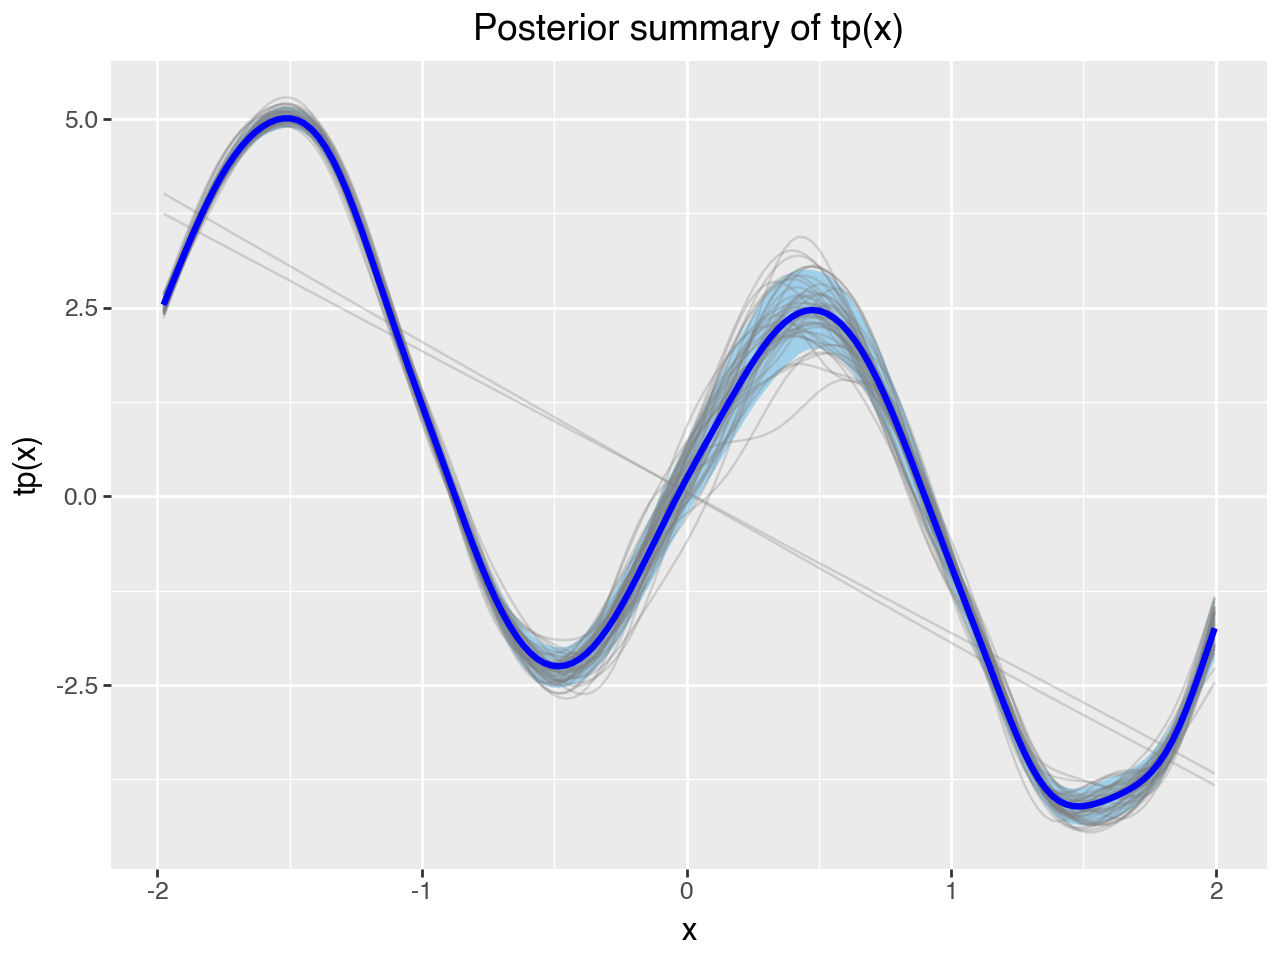

In [16]:
gam.plot_1d_smooth(term=model.vars["tp(x)"], samples=samples)

In [17]:
gam.plot_1d_smooth(term=model.vars["tp(x)2"], samples=samples)

KeyError: 'tp(x)2'